# Сборный проект —2

## Описание проекта

Позади много уроков и заданий, и закрепить свои знания, как обычно, вы сможете в самостоятельном проекте. Это непростой проект, в котором от вас потребуется больше самостоятельности. Этапы работы описаны кратко, и вам понадобится декомпозировать задачи, то есть разделить их на более мелкие. Опирайтесь на знания об этапах анализа данных и машинного обучения из прошлых курсов.

Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Теперь расскажем подробнее о задачах.

## Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!pip install phik -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_classif

## Шаг 1. Загрузка данных

In [3]:
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
def primary_information(df):
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [5]:
primary_information(train_job_satisfaction_rate)

Размерность: (4000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
primary_information(test_features)

Размерность: (2000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
primary_information(test_target_job_satisfaction_rate)

Размерность: (2000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id')
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')

### Промежуточный вывод
Было успешно выгружено три датасета:
- Тренировочная выборка
- Входные признаки тестовой выборки
- Целевой признак тестовой выборки

Первичный анализ показал следующее:
- Датасет тренировочной выборки имеет пропущенные значения:
    - `dept` - 6 позиций
    - `level` - 4 позиции
- Датасет входных признаков тестовой выборки имеет пропущенные значения:
    - `dept` - 2 позиции
    - `level` - 1 позиция
- Датасет целевого признака тестовой выборки пропущенных значений не имеет


## Шаг 2. Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [9]:
train_job_satisfaction_rate.isna().sum()

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [10]:
test_job_satisfaction_rate = test_features.join(test_target_job_satisfaction_rate, how='inner')

In [11]:
test_job_satisfaction_rate.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [12]:
col_names = {
    'dept': 'Отдел',
    'level': 'Уровень занимаемой должности',
    'workload': 'Уровень загруженности',
    'employment_years': 'Длительность работы',
    'last_year_promo': 'Наличие повышения',
    'last_year_violations': 'Наличие нарушений трудового договора',
    'supervisor_evaluation': 'оценка качества работы сотрудника', 
    'salary': 'Зарплата',
    'job_satisfaction_rate': 'Уровень удовлетворённости сотрудника'

}
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Создадим пайплайн для заполнения пропусков с помощью `SimpleImputer`:

In [13]:
ord_pipe = Pipeline(
    [
        ('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ]
)

In [14]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
    ], 
    remainder='passthrough'
) 

In [15]:
pd.DataFrame(data_preprocessor.fit_transform(train_job_satisfaction_rate), columns=train_job_satisfaction_rate.columns).isna().sum()

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пайплайн со совей задачей справляется, идем дальше

Проверим датасеты на наличие дубликатов:

In [16]:
train_job_satisfaction_rate[train_job_satisfaction_rate.duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
302957,purchasing,junior,low,1,no,no,4,15600,0.61
752399,sales,middle,low,7,no,no,4,28800,0.77
802286,sales,junior,medium,1,no,no,4,21600,0.43
167303,sales,junior,medium,1,no,no,3,24000,0.34
191841,sales,junior,medium,1,no,no,5,21600,0.44
...,...,...,...,...,...,...,...,...,...
737303,sales,middle,medium,3,no,no,4,33600,0.47
281204,technology,junior,low,2,no,no,4,15600,0.68
261436,sales,middle,low,3,no,no,3,22800,0.18


In [17]:
test_features[test_features.duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
523542,marketing,junior,low,1,no,no,3,16800
582128,sales,middle,high,5,no,no,4,48000
482624,technology,middle,medium,4,yes,no,2,44400
770429,hr,junior,medium,1,no,no,4,30000
761490,sales,junior,low,1,no,no,4,15600
...,...,...,...,...,...,...,...,...
760964,sales,junior,medium,3,no,no,5,21600
380255,sales,middle,medium,8,no,no,4,38400
393147,marketing,junior,low,3,no,no,3,20400


In [18]:
test_target_job_satisfaction_rate[test_target_job_satisfaction_rate.duplicated()]

,job_satisfaction_rate
id,
161234,0.74
700796,0.23
193643,0.64
709552,0.79
622918,0.77
...,...
405257,0.28
370925,0.21
857722,0.39


Дубликаты отсутствуют. Проверим наличие неявных дубликатов

In [19]:
for category in ord_columns + ohe_columns:
    print(f"{col_names[category]} - {train_job_satisfaction_rate[category].unique()}")
    print(f"{col_names[category]} - {test_features[category].unique()}")

Отдел - ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Отдел - ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уровень занимаемой должности - ['junior' 'middle' 'sinior' nan]
Уровень занимаемой должности - ['junior' 'middle' 'sinior' nan]
Уровень загруженности - ['medium' 'high' 'low']
Уровень загруженности - ['medium' 'low' 'high' ' ']
Наличие повышения - ['no' 'yes']
Наличие повышения - ['no' 'yes']
Наличие нарушений трудового договора - ['no' 'yes']
Наличие нарушений трудового договора - ['no' 'yes']


Неявные дубликаты отсутствуют

## Шаг 3. Исследовательский анализ данных

Объявим функции, необходимые для отображения графической информации

In [20]:
def show_boxbar_for_group(df, column, columns, cols):
    rows = ((len(columns) + cols - 1) // cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))
    for i in range(len(columns)):
        sns.boxplot(x = columns[i], y = column, data = df, ax=axs[i // cols][i % cols])
        axs[i // cols][i % cols].set_xlabel(col_names[columns[i]])
        axs[i // cols][i % cols].set_ylabel('')
    fig.suptitle(col_names[column], fontsize=30)

In [21]:
def show_hist_for_group(df, column, columns, cols, main_title):
    rows = ((len(columns) + cols - 1) // cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))
    for i in range(len(columns)):
        sns.histplot(x = columns[i], hue = column, data = df, multiple = "dodge", ax=axs[i // cols][i % cols])
    fig.suptitle(main_title, fontsize=30)

In [22]:
def show_pie(df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), sharey=True, figsize=(18, 6))
    if len(columns) == 1:
        (
            df[columns[0]].value_counts().plot.pie(autopct='%1.f%%', legend=False,
                wedgeprops = {"edgecolor" : "white", 
                              'linewidth': 2, 
                              'antialiased': True})
        )
        axes.title.set_text(columns[0])
    else:
        idx = 0
        for column in columns:    
            (
                df[column].value_counts().plot.pie(ax=axes[idx], autopct='%1.f%%', legend=False,
                    wedgeprops = {"edgecolor" : "white", 
                                  'linewidth': 2, 
                                  'antialiased': True})
            )
            axes[idx].title.set_text(col_names[columns[idx]])
            idx+=1

In [23]:
def show_scatterplot_with_job_satisfaction_rated(df, y, columns, cols):
    rows = ((len(columns) + cols - 1) // cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))
    for i in range(len(columns)):
        sns.scatterplot(data=df, x='job_satisfaction_rate', y=y, hue=columns[i], ax=axs[i // cols][i % cols])
    fig.suptitle(f"Диаграммы рассеяния для уровня\nудовлетворённости сотрудника и {col_names[y]}", fontsize=30)

Построим ящики с усами количественных переменных по всем данным

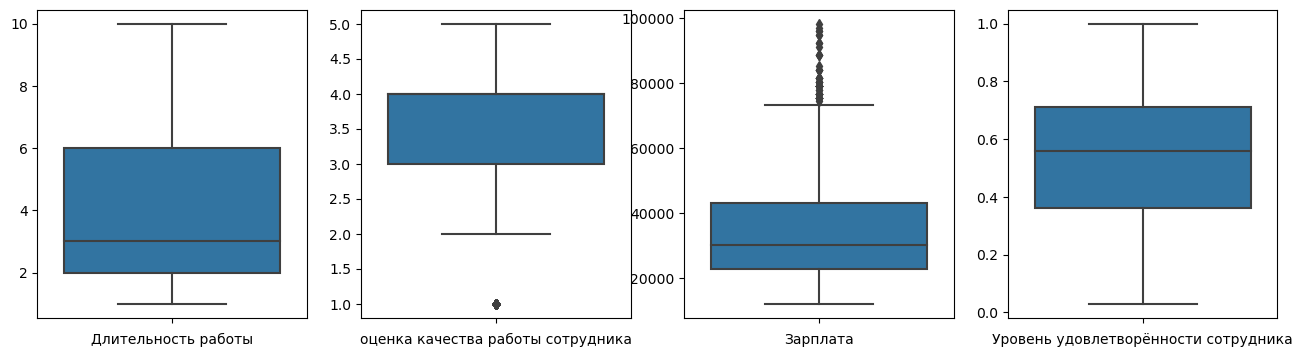

In [24]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))
i = 0
for boxplot_col in num_columns:
    sns.boxplot(data = train_job_satisfaction_rate, y=boxplot_col, ax=axs[i])
    axs[i].set_xlabel(col_names[boxplot_col])
    axs[i].set_ylabel('')
    i += 1
fig.suptitle("", fontsize=30);

Построим ящики с усами количественных переменных в разрезе категориальных переменных

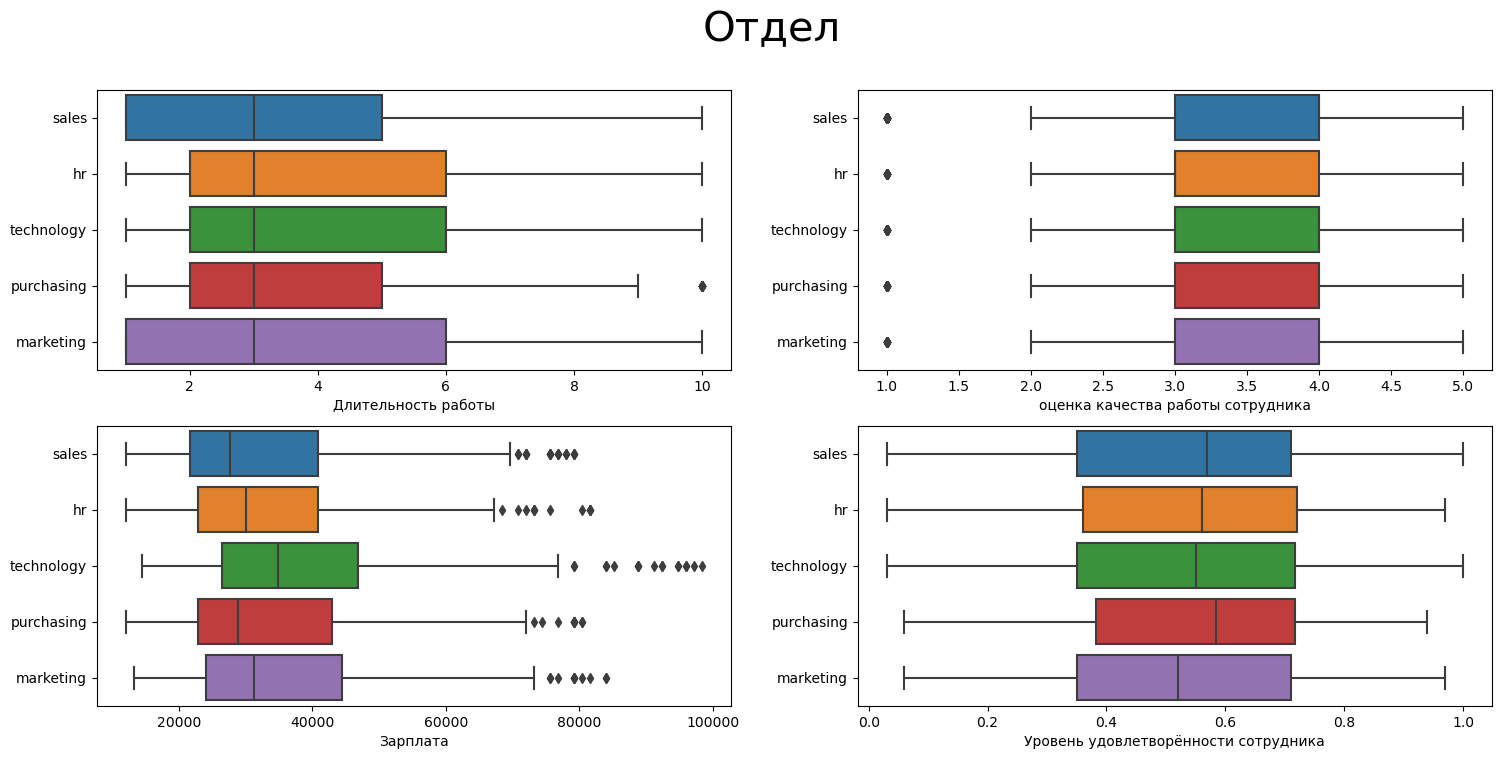

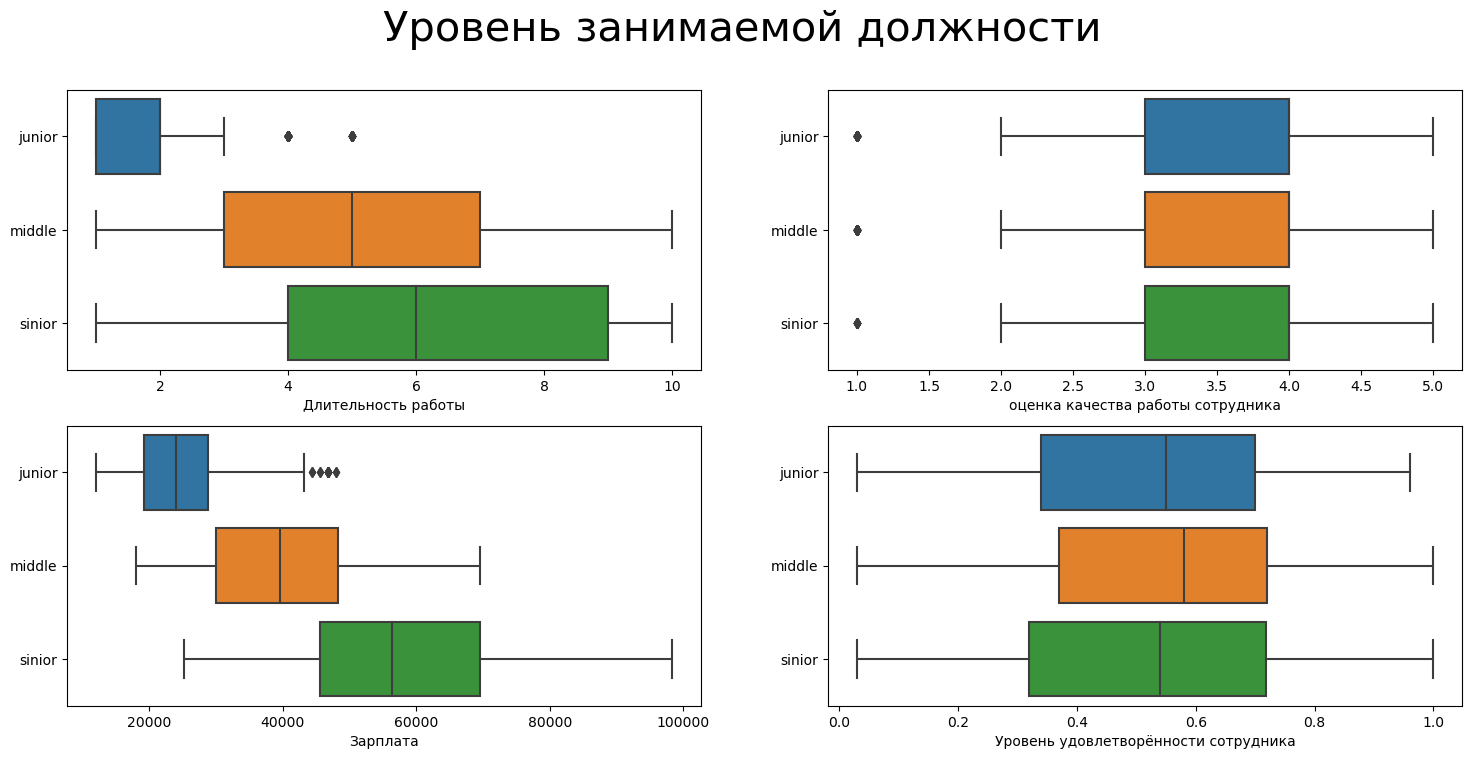

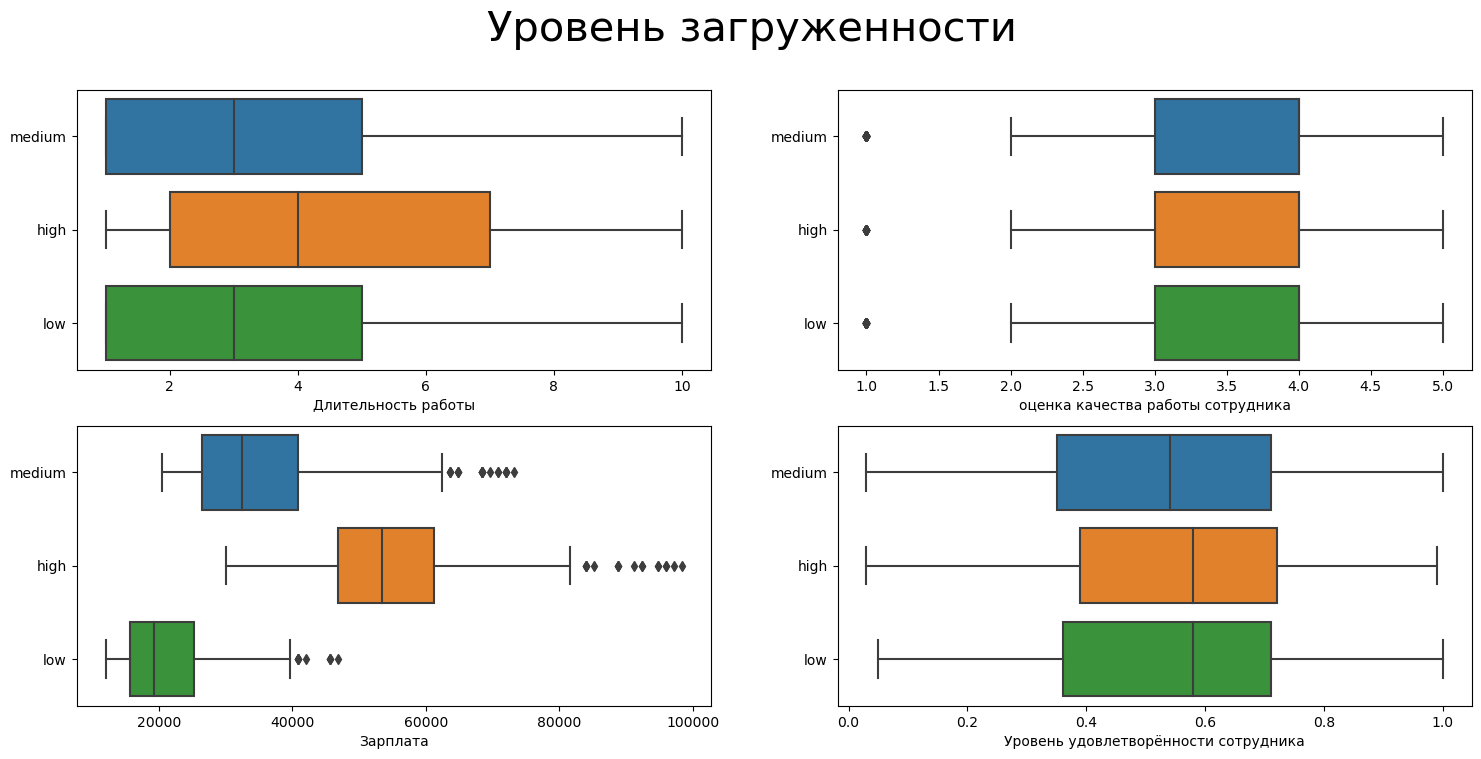

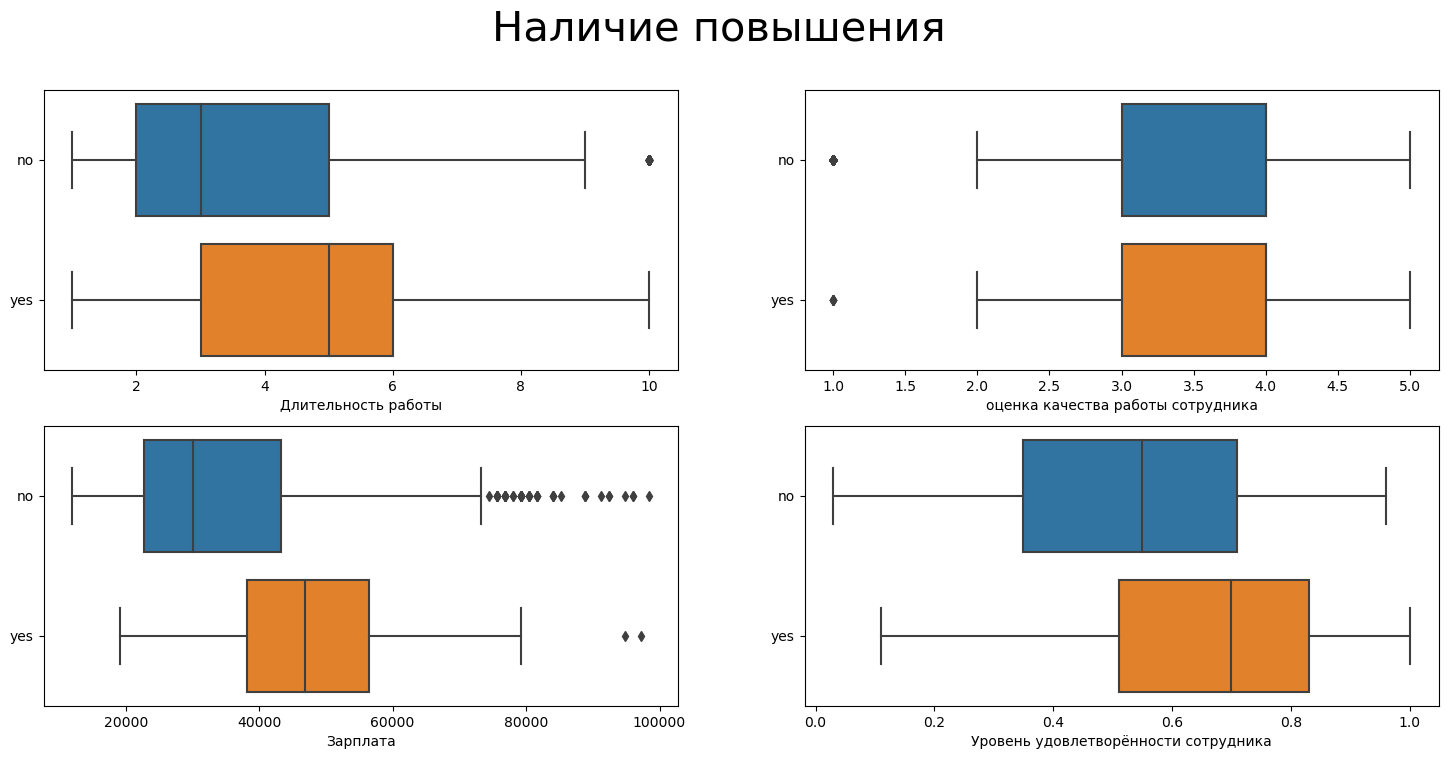

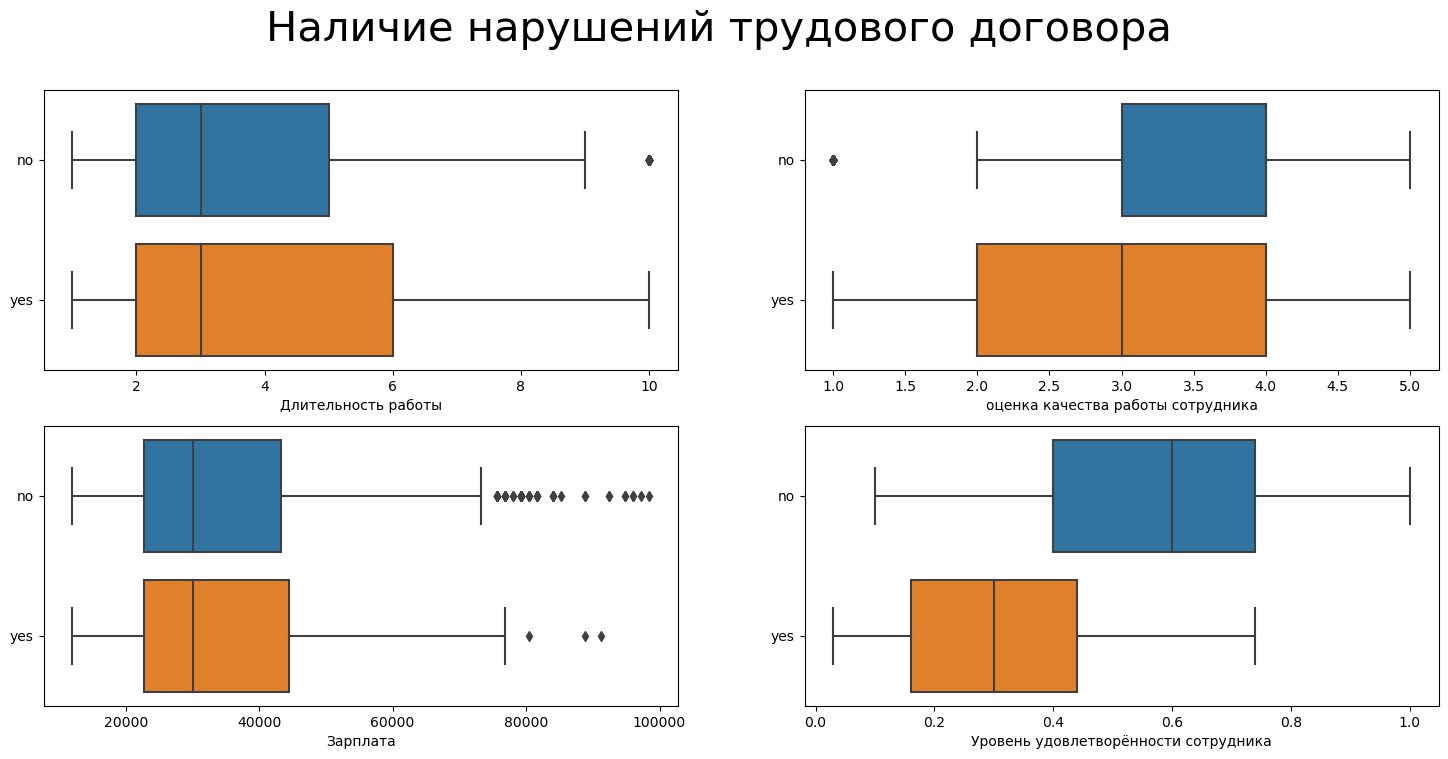

In [25]:
for category in ord_columns + ohe_columns:
    show_boxbar_for_group(
        train_job_satisfaction_rate, 
        category,
        num_columns, 
        2
    )

## Промежуточный вывод
По боксплотам можно заметить, что на уровень удовлетворенности сотрудника оказывают сильное влияние факторы:
- Нарушал ли сотруднки трудовой договор
- Было ли повышение за последний год

Факторы оказывающее меньшее влияние:
- Уровень загруженности
- Отдел, в котором работает сотрудник
- Уровень занимаемой должности

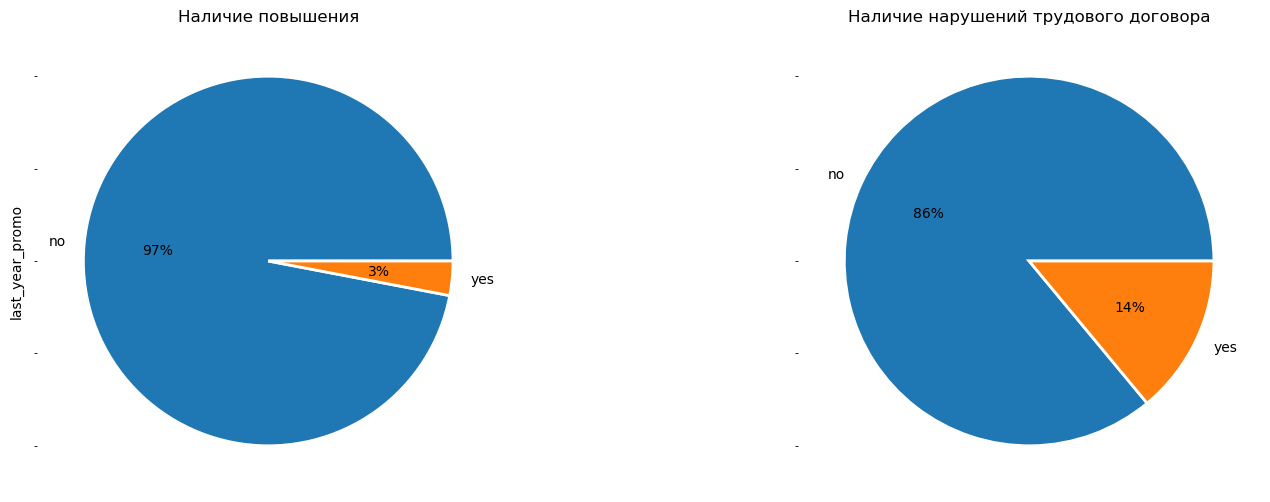

In [26]:
show_pie(
    train_job_satisfaction_rate, 
    ohe_columns
)

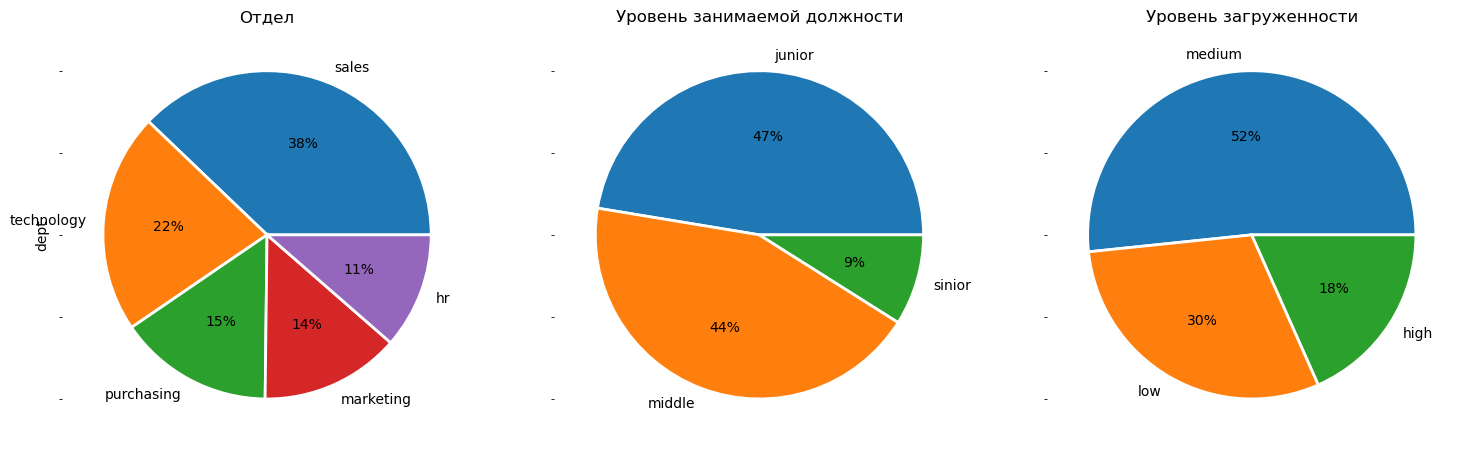

In [27]:
show_pie(
    train_job_satisfaction_rate, 
    ord_columns
)

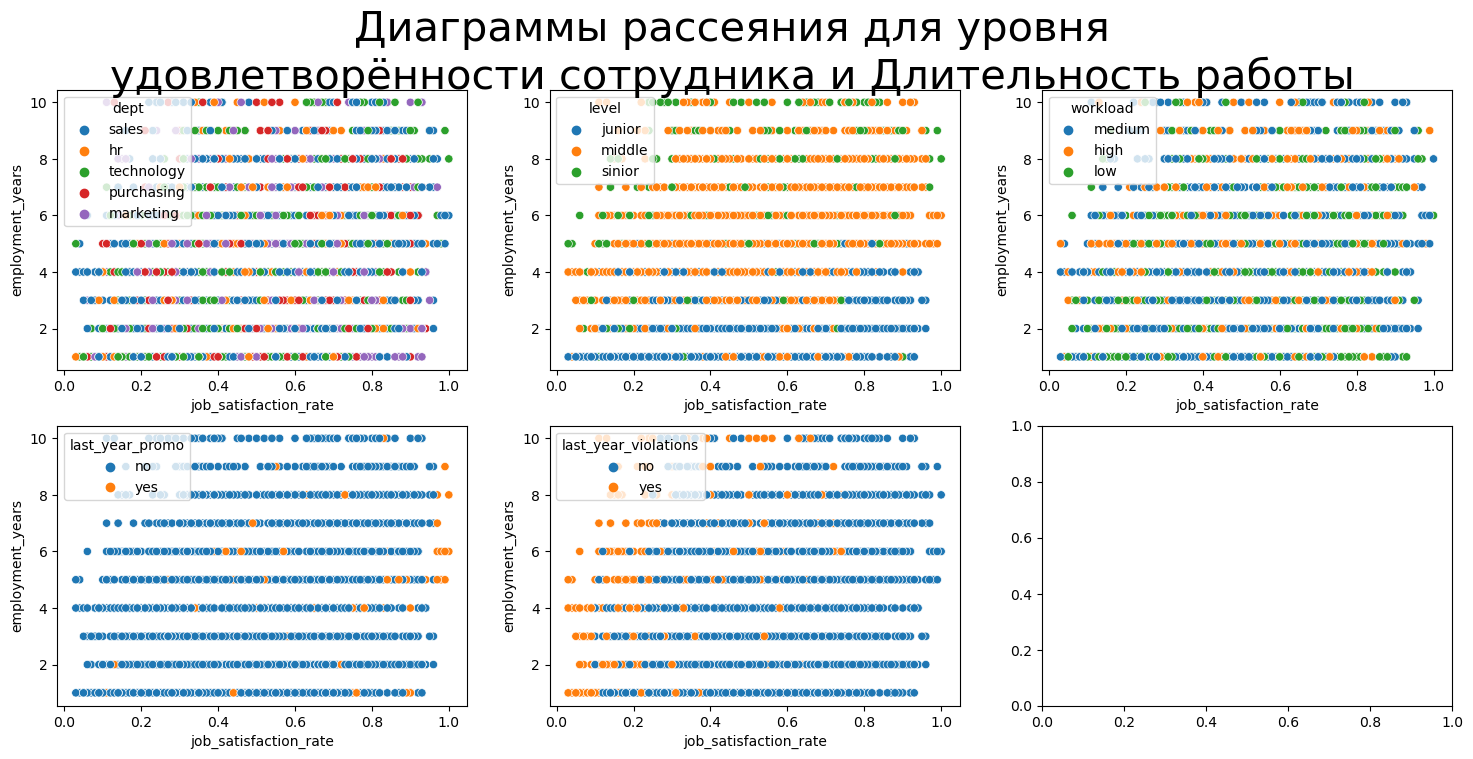

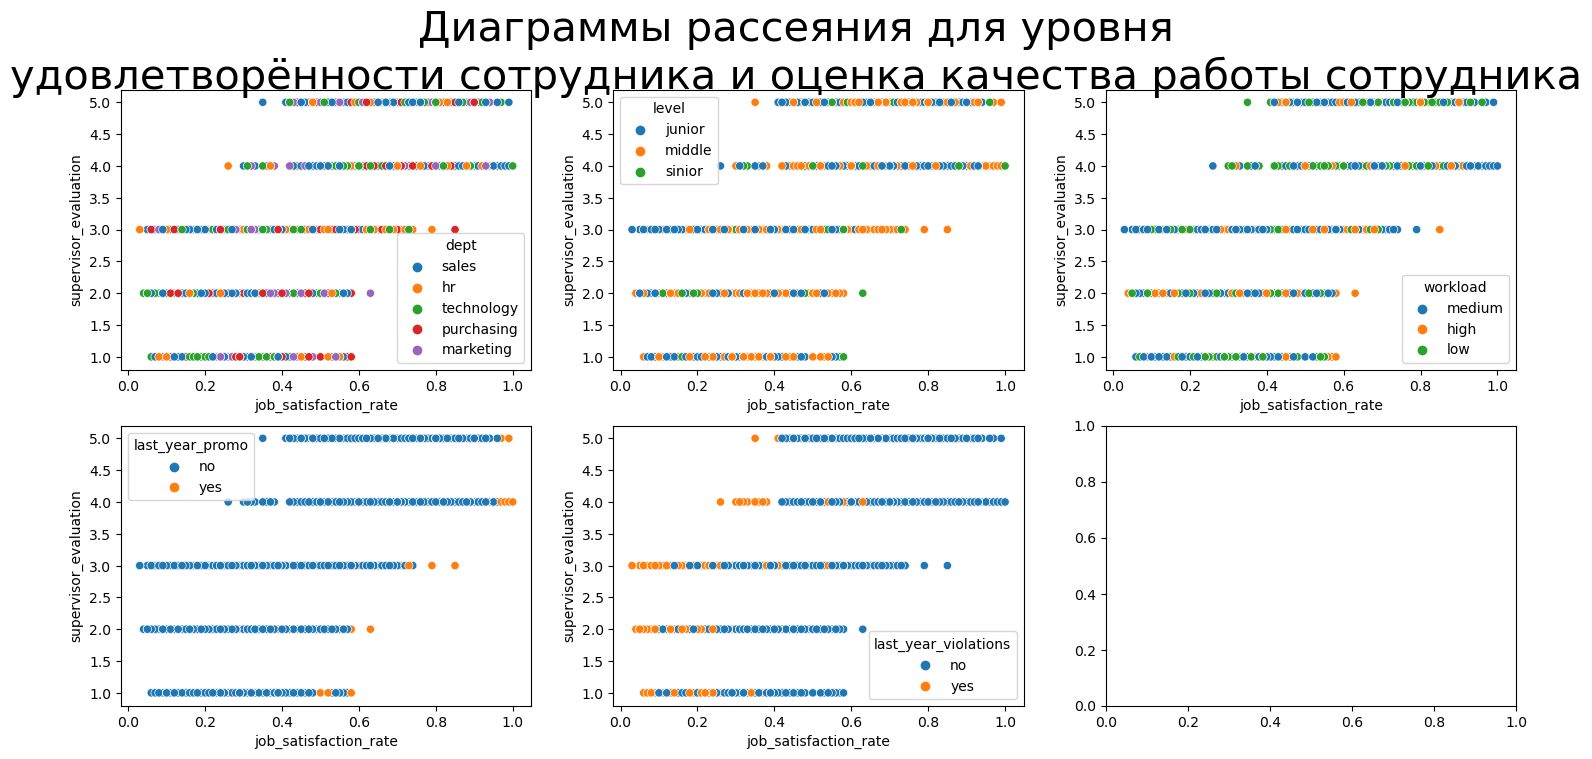

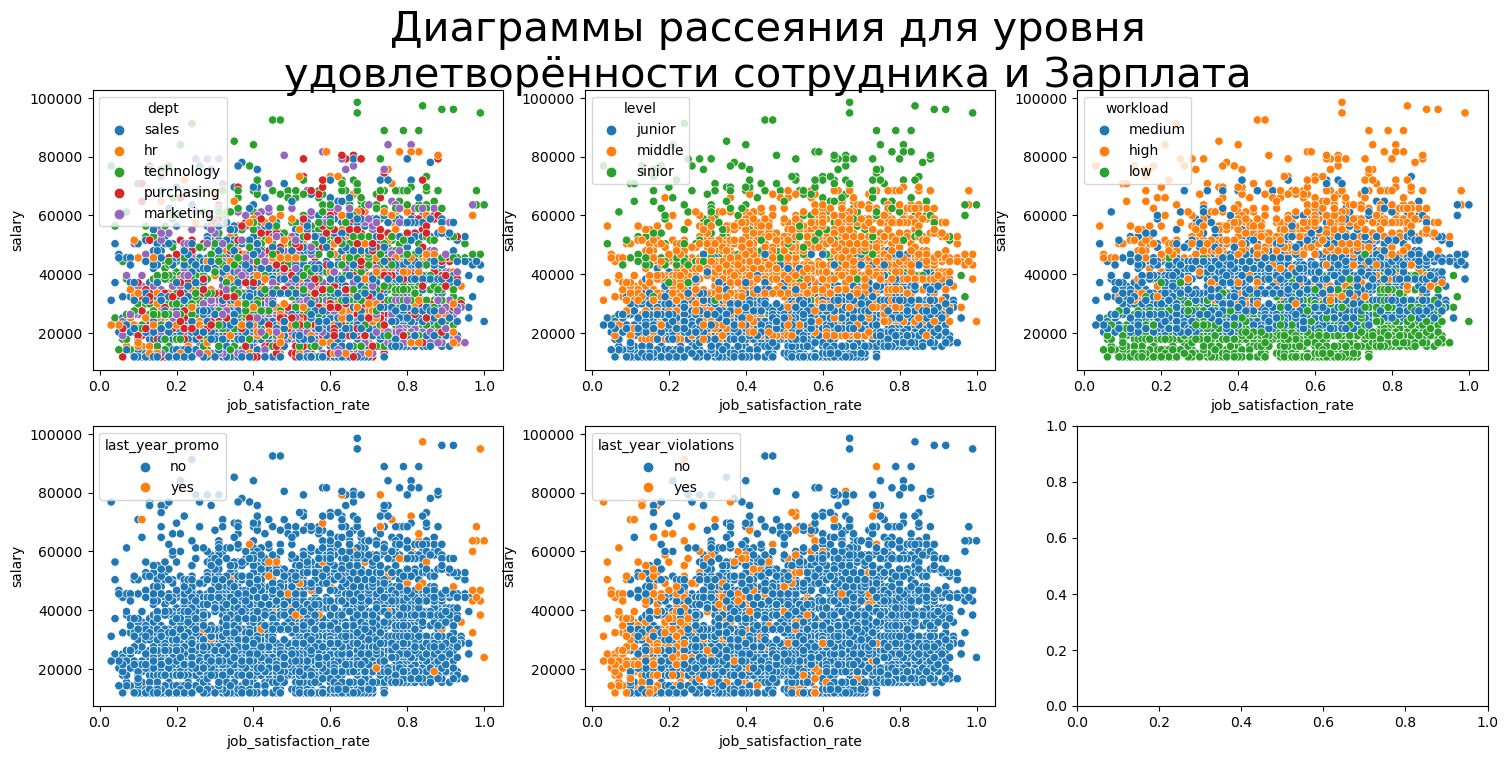

In [28]:
quantitative_vars = ['employment_years', 'supervisor_evaluation', 'salary']
categorical_vars = ['dept','level','workload','last_year_promo','last_year_violations']

for item in quantitative_vars:
    show_scatterplot_with_job_satisfaction_rated(train_job_satisfaction_rate, item, categorical_vars, 3)

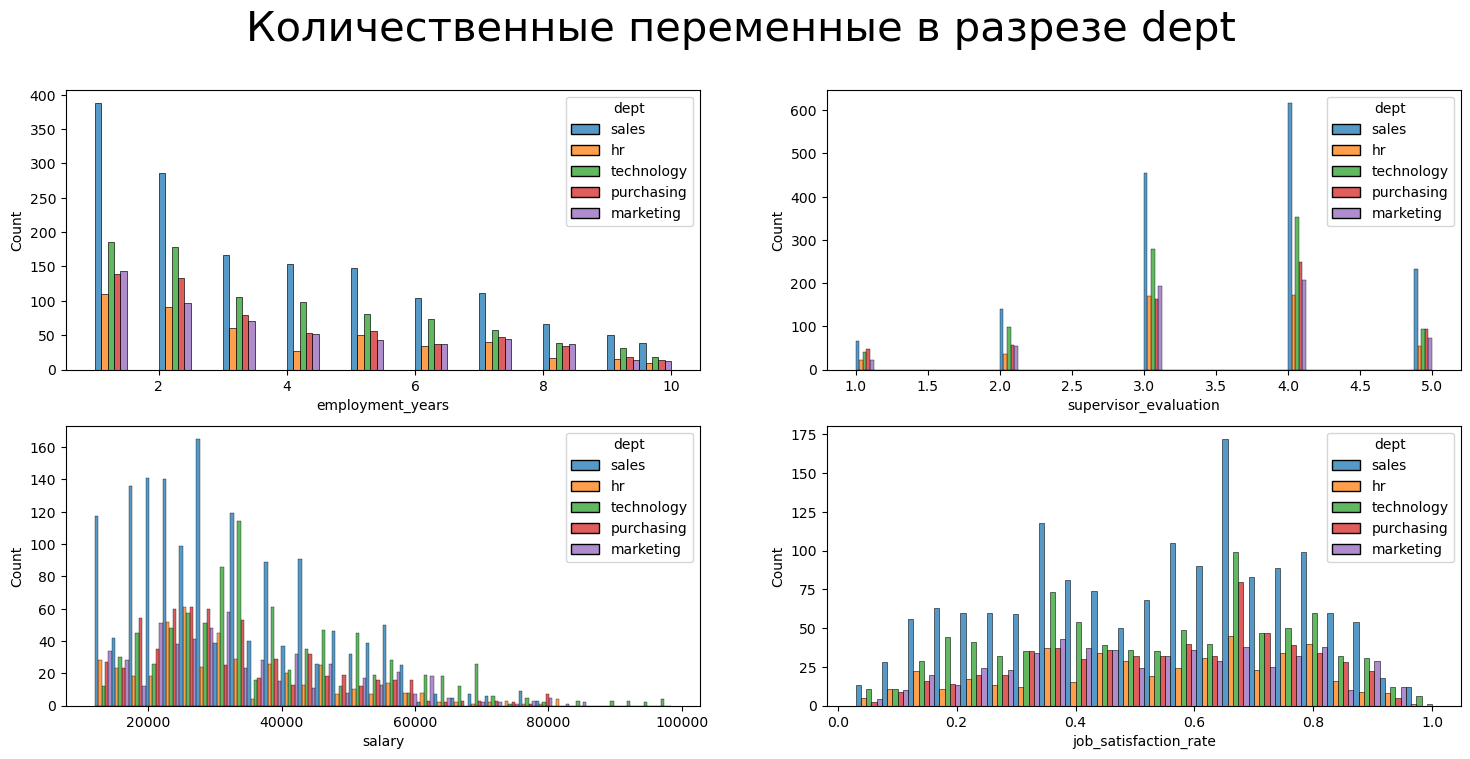

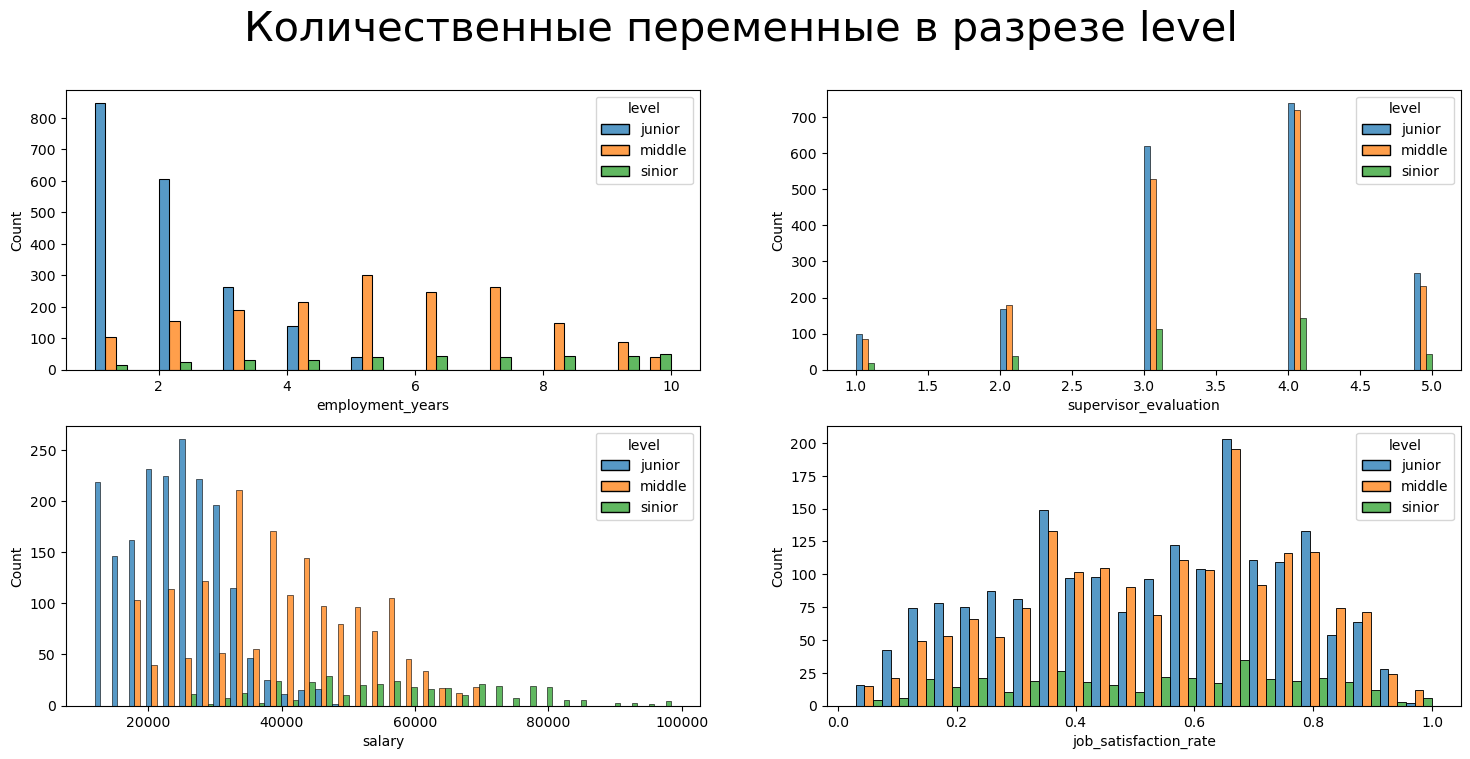

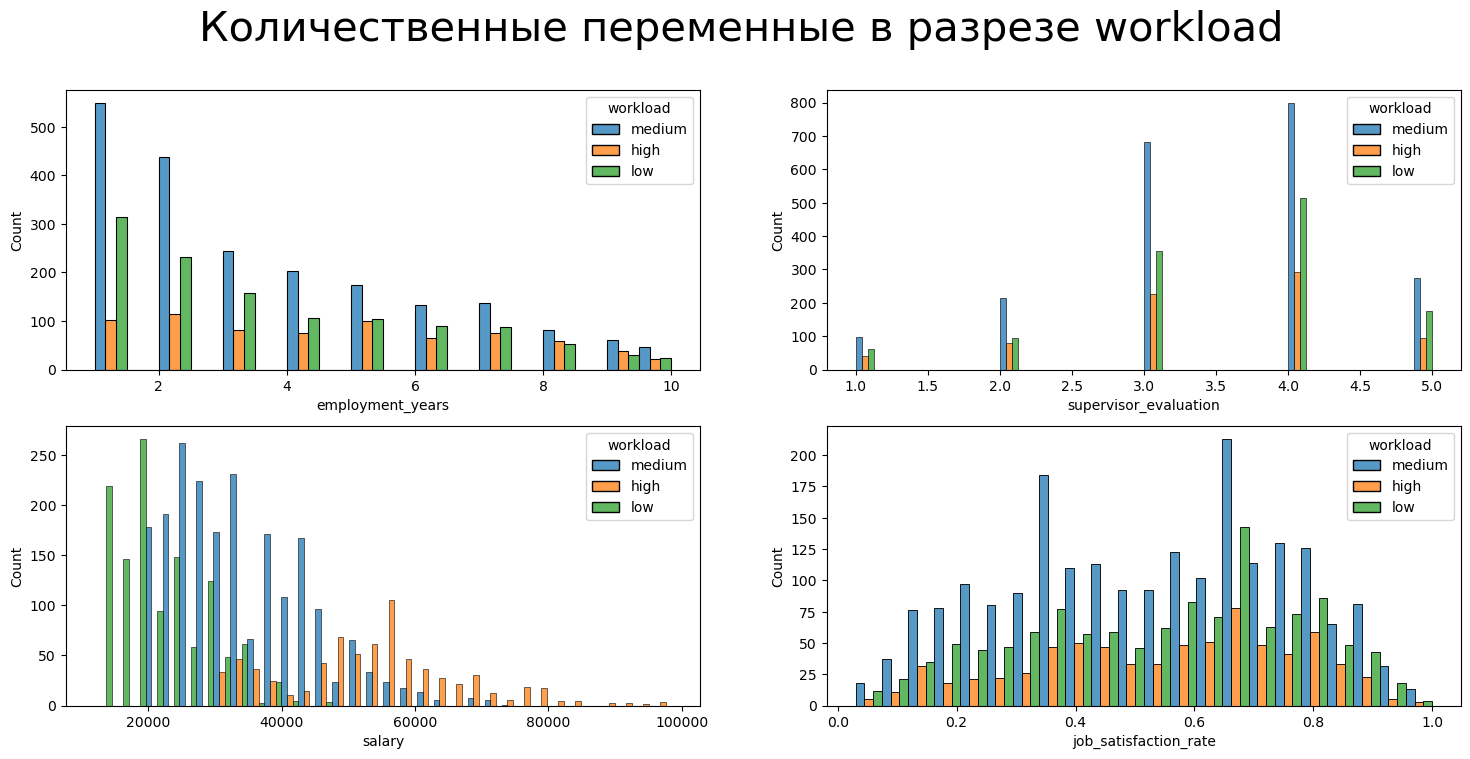

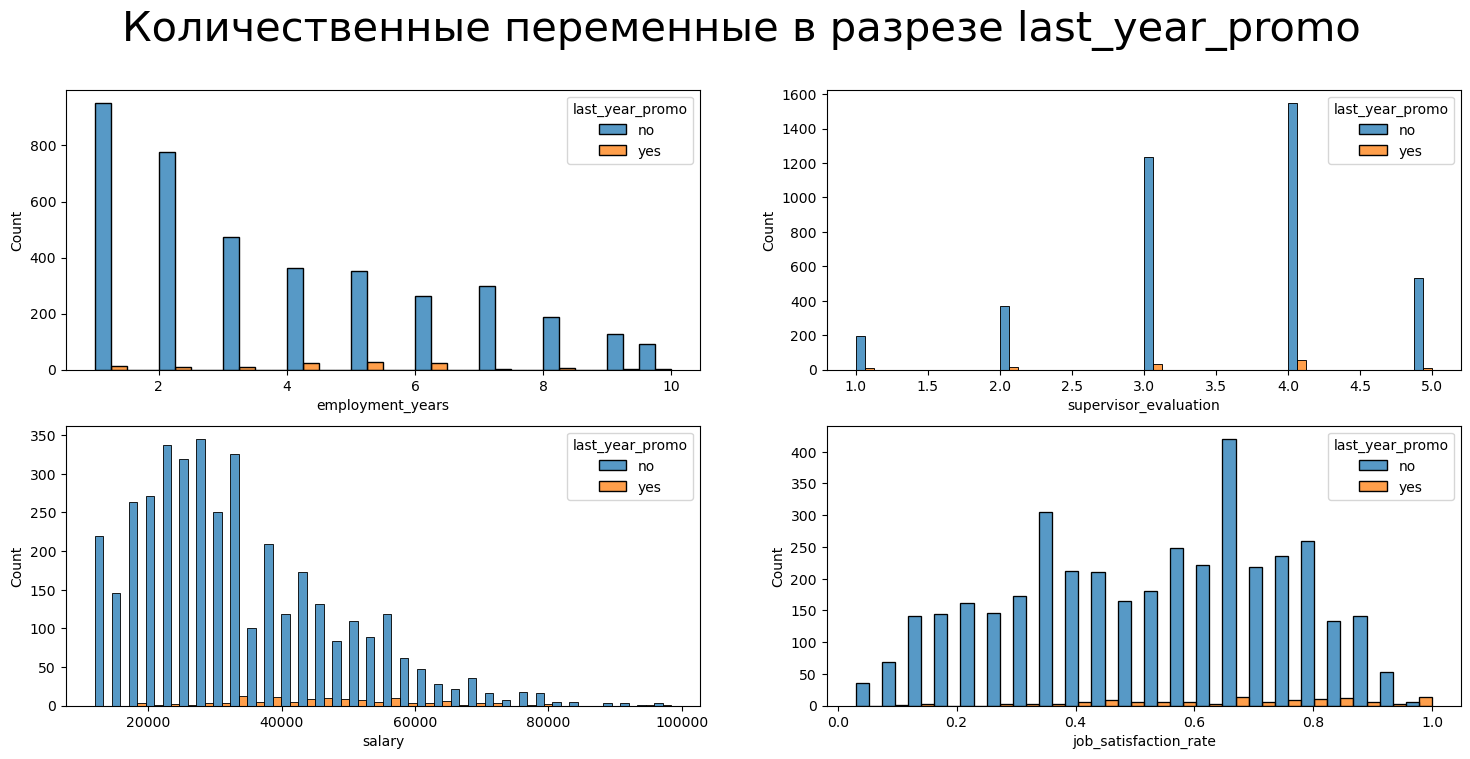

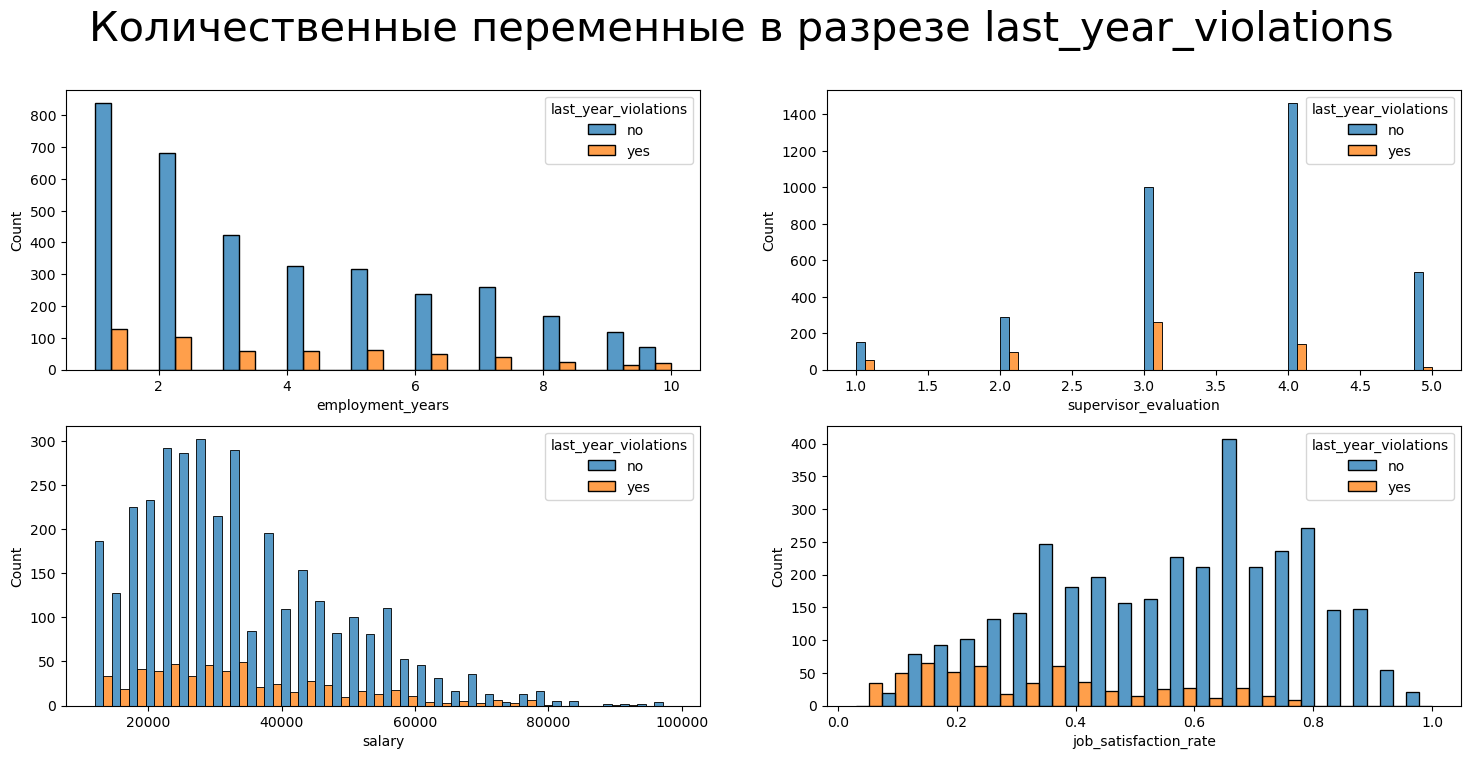

In [29]:
for category in ord_columns + ohe_columns:
    show_hist_for_group(
        train_job_satisfaction_rate, 
        category,
        num_columns, 
        2,
        f'Количественные переменные в разрезе {category}'
    )

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


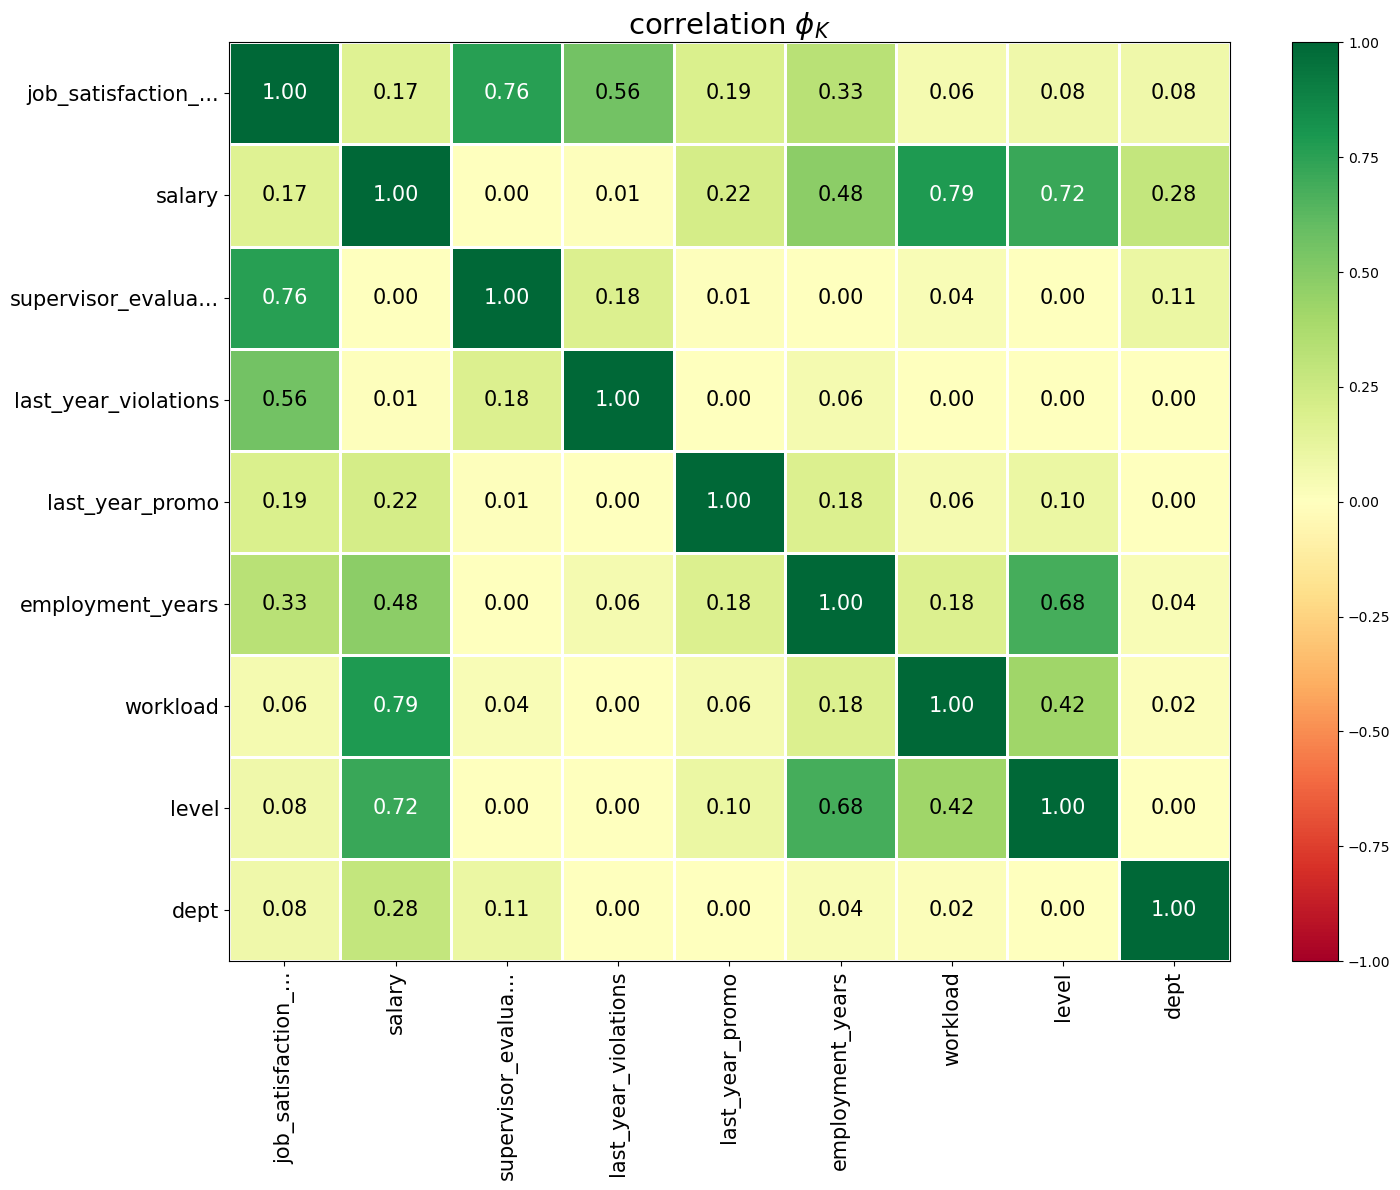

In [30]:
phik_overview = train_job_satisfaction_rate.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

Мультиколлинеарности не обнаружено

## Шаг 4. Подготовка данных

Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [31]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [32]:
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_job_satisfaction_rate[ohe_columns+ord_columns+num_columns],
    train_job_satisfaction_rate['job_satisfaction_rate'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train_job_satisfaction_rate['job_satisfaction_rate'])

X_test = test_job_satisfaction_rate[ohe_columns+ord_columns+num_columns]
y_test = test_job_satisfaction_rate['job_satisfaction_rate']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((3000, 8), (3000,), (1000, 8), (1000,), (2000, 8), (2000,))

Создадим пайплайн предобрабочиков

In [34]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [35]:
X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_valid_preprocessed = data_preprocessor.transform(X_valid)
X_test_preprocessed = data_preprocessor.transform(X_test)

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


## Шаг 5. Обучение моделей

Для начала создадим метрику SMAPE:

In [36]:
def smape_scorer(y_true, y):
    numerator = abs(y_true-y)
    denominator = (abs(y_true)+abs(y))/2
    metric = 100 * (numerator / denominator).mean()
    return metric

In [37]:
smape_score = make_scorer(smape_scorer, greater_is_better=False)

In [38]:
poly_model = Pipeline([('poly', PolynomialFeatures()),
                      ('linear', LinearRegression(fit_intercept=False))])
param_grid = {
    'poly__degree': range(1, 6)
}
grid_search = GridSearchCV(
    poly_model, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1
)
grid_search.fit(X_train_preprocessed, y_train)
best_poly_model = grid_search.best_estimator_
print (f"Метрика SMAPE модели LinearRegression на тренировочной выборке: {grid_search.best_score_:.2f}")

y_valid_pred = best_poly_model.predict(X_valid_preprocessed)
y_test_pred = best_poly_model.predict(X_test_preprocessed)
print (f"Метрика SMAPE модели LinearRegression на валидационной выборке: {smape_scorer(y_valid, y_valid_pred):.2f}")
print (f"Метрика SMAPE модели LinearRegression на тестовой выборке: {smape_scorer(y_test, y_test_pred):.2f}")
print ('Лучшая модель:', best_poly_model)

Метрика SMAPE модели LinearRegression на тренировочной выборке: -19.25
Метрика SMAPE модели LinearRegression на валидационной выборке: 16.62
Метрика SMAPE модели LinearRegression на тестовой выборке: 16.59
Лучшая модель: Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('linear', LinearRegression(fit_intercept=False))])


In [39]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_preprocessed, y_train);
param_grid = {
    'max_depth': range(2, 15),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5)
}
grid_search = GridSearchCV(
    tree_model, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1
)
grid_search.fit(X_train_preprocessed, y_train)
best_tree_model = grid_search.best_estimator_
print (f'Метрика SMAPE модели DecisionTreeRegressor на тренировочной выборке: {grid_search.best_score_:.2f}')

y_valid_pred = best_tree_model.predict(X_valid_preprocessed)
y_test_pred = best_tree_model.predict(X_test_preprocessed)
print (f'Метрика SMAPE модели DecisionTreeRegressor на валидационной выборке: {smape_scorer(y_valid, y_valid_pred):.2f}')
print (f'Метрика SMAPE модели DecisionTreeRegressor на тестовой выборке: {smape_scorer(y_test, y_test_pred):.2f}')
print ('Лучшая модель:', best_tree_model)

Метрика SMAPE модели DecisionTreeRegressor на тренировочной выборке: -15.77
Метрика SMAPE модели DecisionTreeRegressor на валидационной выборке: 14.90
Метрика SMAPE модели DecisionTreeRegressor на тестовой выборке: 14.93
Лучшая модель: DecisionTreeRegressor(max_depth=14, min_samples_leaf=3)


In [40]:
best_model = best_tree_model

## Промежуточный вывод
Были обучены две модели:
- Линейная регрессия
- Дерево решений

Перебром гиперпараметров и оценкой с помощью SMAPE метрики были получены лучшие настройки для каждой модели:
- Линейная регрессия с полиномиальной функцией четвертой степени
- Дерево решений с параметрами max_depth=14, min_samples_leaf=3, min_samples_split=3

Лучших результатов на тестовой выборке достигла модель DecisionTreeRegressor

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

In [41]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

## Шаг 2. Предобработка данных
Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [42]:
primary_information(train_quit)

Размерность: (4000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [43]:
train_quit = train_quit.set_index('id')
test_features = test_features.set_index('id')
test_target_quit = test_target_quit.set_index('id')

In [44]:
primary_information(test_target_quit)

Размерность: (2000, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


In [45]:
train_quit[train_quit.duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
873412,technology,junior,medium,2,no,no,4,31200,no
749683,sales,middle,low,8,no,no,4,19200,no
689526,marketing,middle,low,6,no,no,3,30000,no
786443,purchasing,middle,low,6,no,no,4,19200,no
362060,sales,junior,low,1,no,no,4,12000,yes
...,...,...,...,...,...,...,...,...,...
632886,sales,junior,low,3,no,no,4,12000,no
387733,marketing,middle,medium,5,no,no,3,44400,no
588809,sales,junior,medium,4,no,no,3,26400,no


In [46]:
test_target_quit = test_features.join(test_target_quit, how='inner')

Данные без пропусков и дубликатов, можем приступать к анализу

## Шаг 3. Исследовательский анализ данных
3.1. Проведите исследовательский анализ данных.

3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [47]:
col_names = {
    'dept': 'Отдел',
    'level': 'Уровень занимаемой должности',
    'workload': 'Уровень загруженности',
    'employment_years': 'Длительность работы',
    'last_year_promo': 'Наличие повышения',
    'last_year_violations': 'Наличие нарушений трудового договора',
    'supervisor_evaluation': 'оценка качества работы сотрудника', 
    'salary': 'Зарплата',
    'quit': 'Уволился',
    'job_satisfaction_rate': 'Уровень удовлетворённости сотрудника'

}
ohe_columns = ['last_year_promo', 'last_year_violations', 'quit']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

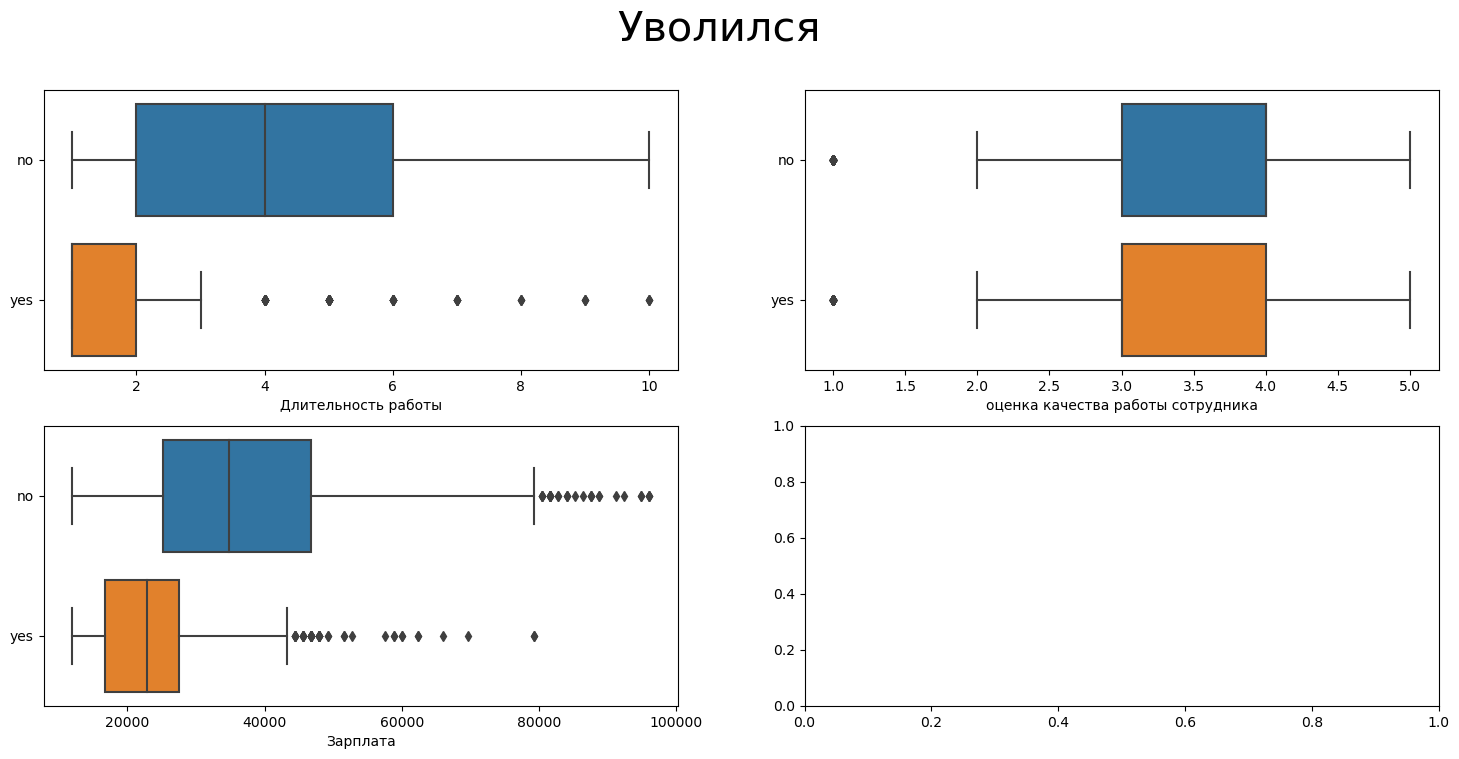

In [48]:
show_boxbar_for_group(train_quit, 'quit', num_columns, 2)

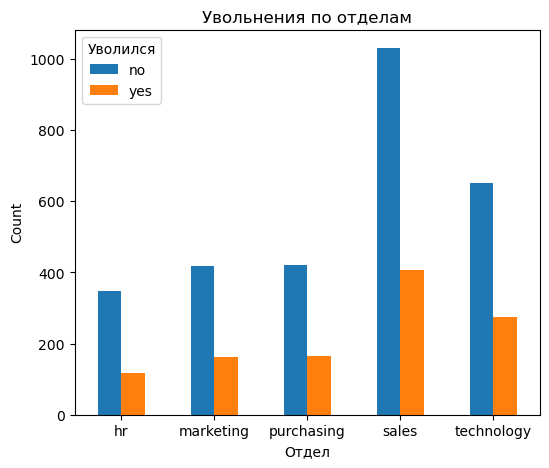

In [49]:
ax = train_quit.groupby(['dept']).quit.value_counts().unstack().plot(kind='bar', figsize=(6, 5), xlabel='Отдел', ylabel='Count', rot=0)
ax.legend(title='Уволился', bbox_to_anchor=(0, 1), loc='upper left')
ax.set_title("Увольнения по отделам");

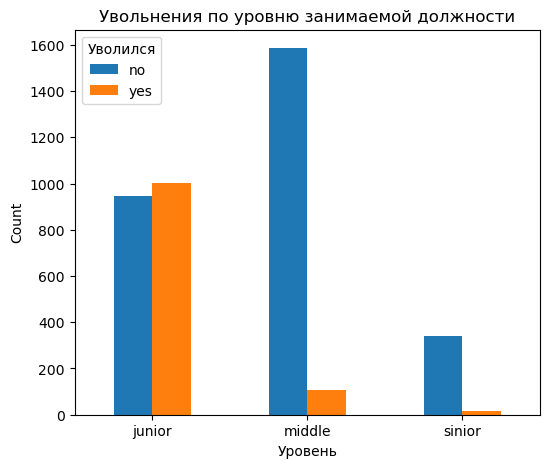

In [50]:
ax = train_quit.groupby(['level']).quit.value_counts().unstack().plot(kind='bar', figsize=(6, 5), xlabel='Уровень', ylabel='Count', rot=0)
ax.legend(title='Уволился', bbox_to_anchor=(0, 1), loc='upper left')
ax.set_title("Увольнения по уровню занимаемой должности");

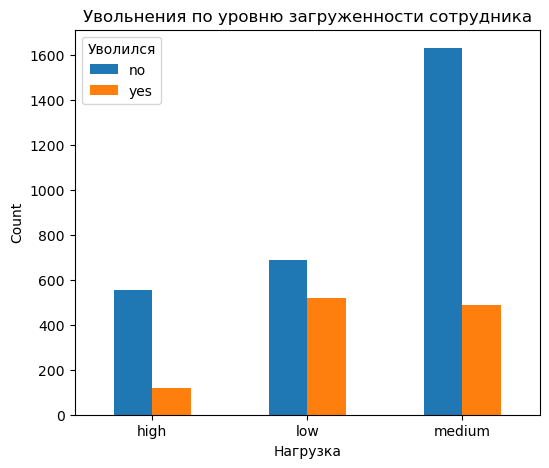

In [51]:
ax = train_quit.groupby(['workload']).quit.value_counts().unstack().plot(kind='bar', figsize=(6, 5), xlabel='Нагрузка', ylabel='Count', rot=0)
ax.legend(title='Уволился', bbox_to_anchor=(0, 1), loc='upper left')
ax.set_title("Увольнения по уровню загруженности сотрудника");

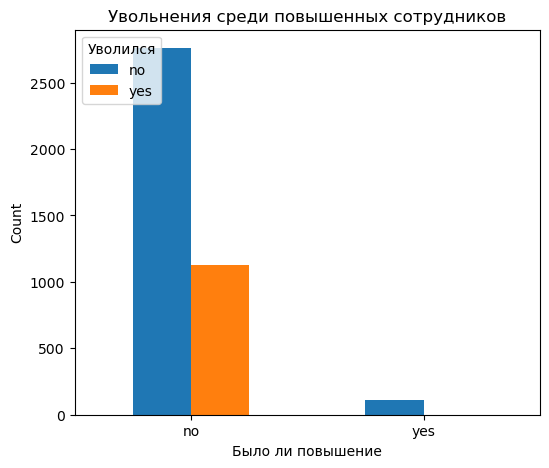

In [52]:
ax = train_quit.groupby(['last_year_promo']).quit.value_counts().unstack().plot(kind='bar', figsize=(6, 5), xlabel='Было ли повышение', ylabel='Count', rot=0)
ax.legend(title='Уволился', bbox_to_anchor=(0, 1), loc='upper left')
ax.set_title("Увольнения среди повышенных сотрудников");

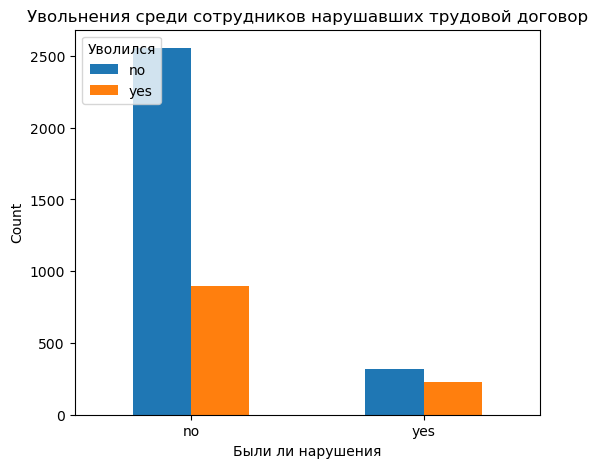

In [53]:
ax = train_quit.groupby(['last_year_violations']).quit.value_counts().unstack().plot(kind='bar', figsize=(6, 5), xlabel='Были ли нарушения', ylabel='Count', rot=0)
ax.legend(title='Уволился', bbox_to_anchor=(0, 1), loc='upper left')
ax.set_title("Увольнения среди сотрудников нарушавших трудовой договор");

## Промежуточный вывод
По графикам, полученным в результате анализа, можно составить портрет «уволившегося сотрудника»:
- Отработал в среднем менее трех лет
- Зарплата менее 30000
- Уровень junior
- Нагрузка слабая
- Не было повышений за последний год
- Были нарушения трудового договора

Соединим тестовые выборки, чтобы проверить, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

In [54]:
df_full_test = test_target_quit.join(test_job_satisfaction_rate['job_satisfaction_rate'], how='inner')
primary_information(df_full_test)

Размерность: (2000, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   quit                   2000 non-null   object 
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 236.4+ KB


None

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
686555,hr,junior,medium,1,no,no,4,30000,no,0.72
467458,sales,middle,low,5,no,no,4,19200,no,0.64
418655,sales,middle,low,6,no,no,4,19200,no,0.60
789145,hr,middle,medium,5,no,no,5,40800,no,0.75


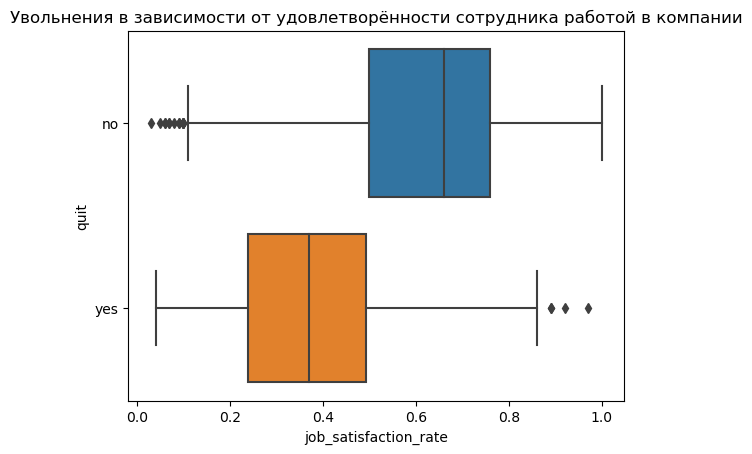

In [55]:
ax = sns.boxplot(x = 'job_satisfaction_rate', y = 'quit', data = df_full_test)
ax.set_title("Увольнения в зависимости от удовлетворённости сотрудника работой в компании");

## Промежуточный вывод
Действительно, уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

## Шаг 4. Добавление нового входного признака
Допустим, `job_satisfaction_rate` и `quit` действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [56]:
X_preprocessed = data_preprocessor.transform(train_quit.drop('quit', axis=1))
train_quit['job_satisfaction_rate'] = best_model.predict(X_preprocessed)
primary_information(train_quit)

Размерность: (4000, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB


None

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.640000
814010,sales,junior,medium,2,no,no,4,27600,no,0.829412
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.366667
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.353333
910140,marketing,junior,medium,2,no,no,5,25200,no,0.768000


## Шаг 5. Подготовка данных
Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [57]:
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df_full_test[ohe_columns+ord_columns+num_columns],
    df_full_test['quit'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full_test['quit'])

X_test = df_full_test[ohe_columns+ord_columns+num_columns]

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(df_full_test['quit'])

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1500, 9), (1500,), (500, 9), (500,), (2000, 9), (2000,))

In [59]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [60]:
X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_valid_preprocessed = data_preprocessor.transform(X_valid)
X_test_preprocessed = data_preprocessor.transform(X_test)

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


## Шаг 6. Обучение модели
Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [61]:
logistic_model = LogisticRegression(
    random_state=RANDOM_STATE,
    solver='liblinear',
    penalty='l1'
)
grid_search = GridSearchCV(
    logistic_model, 
    {'C': range(1, 5)}, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_preprocessed, y_train)
best_logistic_model = grid_search.best_estimator_
y_valid_pred_proba = best_logistic_model.predict_proba(X_valid_preprocessed)[:, 1]
y_test_pred_proba = best_logistic_model.predict_proba(X_test_preprocessed)[:, 1]

print (f"Метрика ROC-AUC модели LogisticRegression на тренировочной выборке: {grid_search.best_score_:.2f}")
print (f"Метрика ROC-AUC модели LogisticRegression на валидационной выборке: {roc_auc_score(y_valid, y_valid_pred_proba):.2f}")
print (f"Метрика ROC-AUC модели LogisticRegression на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba):.2f}")
print ('Лучшая модель:', best_logistic_model)

Метрика ROC-AUC модели LogisticRegression на тренировочной выборке: 0.91
Метрика ROC-AUC модели LogisticRegression на валидационной выборке: 0.91
Метрика ROC-AUC модели LogisticRegression на тестовой выборке: 0.91
Лучшая модель: LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')


In [62]:
tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    tree_model, 
    {
        'max_depth': range(2, 11),
        'max_features': range(2, 5)
    }, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_preprocessed, y_train)
best_tree_model = grid_search.best_estimator_
y_valid_pred_proba = best_tree_model.predict_proba(X_valid_preprocessed)[:, 1]
y_test_pred_proba = best_tree_model.predict_proba(X_test_preprocessed)[:, 1]

print (f"Метрика ROC-AUC модели DecisionTreeClassifier на тренировочной выборке: {grid_search.best_score_:.2f}")
print (f"Метрика ROC-AUC модели DecisionTreeClassifier на валидационной выборке: {roc_auc_score(y_valid, y_valid_pred_proba):.2f}")
print (f"Метрика ROC-AUC модели DecisionTreeClassifier на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba):.2f}")
print ('Лучшая модель:', best_tree_model)

Метрика ROC-AUC модели DecisionTreeClassifier на тренировочной выборке: 0.91
Метрика ROC-AUC модели DecisionTreeClassifier на валидационной выборке: 0.90
Метрика ROC-AUC модели DecisionTreeClassifier на тестовой выборке: 0.95
Лучшая модель: DecisionTreeClassifier(max_depth=6, max_features=4, random_state=42)


In [63]:
neighbors_model = KNeighborsClassifier()
grid_search = GridSearchCV(
    neighbors_model, 
    {
        'n_neighbors': range(1, 20),
    }, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_preprocessed, y_train)
best_neighbors_model = grid_search.best_estimator_
y_valid_pred_proba = best_neighbors_model.predict_proba(X_valid_preprocessed)[:, 1]
y_test_pred_proba = best_neighbors_model.predict_proba(X_test_preprocessed)[:, 1]

print (f"Метрика ROC-AUC модели KNeighborsClassifier на тренировочной выборке: {grid_search.best_score_:.2f}")
print (f"Метрика ROC-AUC модели KNeighborsClassifier на валидационной выборке: {roc_auc_score(y_valid, y_valid_pred_proba):.2f}")
print (f"Метрика ROC-AUC модели KNeighborsClassifier на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba):.2f}")
print ('Лучшая модель:', neighbors_model)

Метрика ROC-AUC модели KNeighborsClassifier на тренировочной выборке: 0.93
Метрика ROC-AUC модели KNeighborsClassifier на валидационной выборке: 0.92
Метрика ROC-AUC модели KNeighborsClassifier на тестовой выборке: 0.95
Лучшая модель: KNeighborsClassifier()


Были обучены три модели:
- LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')
- DecisionTreeClassifier(max_depth=6, max_features=4, random_state=42)
- KNeighborsClassifier()

Согласно метрике ROC-AUC лучше всего себя показали модели DecisionTreeClassifier и KNeighborsClassifier с результатом на тестовой выборке 0.95

## Общий вывод
В задаче необходимо было разработать модель машинного обучения для предсказание оттока сотрудников, так как это одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

В результате работы над задачей были выгружены датасеты данных о сотрудниках. Данные были обработаны, устранены пропуски, проверены на дубликаты. Построены графики, позволяющие увидеть различные сегменты сотрудников. Графический анализ позволил определить какие факторы влияют на настроение сотрудника в компании, а именно сильное влияние оказывают факторы:
- Нарушал ли сотрудники трудовой договор
- Было ли повышение за последний год
- Оценка качества работы сотрудника, которую дал руководитель

Факторы оказывающее меньшее влияние:
- Уровень загруженности
- Отдел, в котором работает сотрудник
- Уровень занимаемой должности

Далее были подготовлены и обучены две модели:
- Линейная регрессия
- Дерево решений

Перебром гиперпараметров и оценкой с помощью SMAPE метрики были получены лучшие настройки для каждой модели:
- Линейная регрессия с полиномиальной функцией четвертой степени
- Дерево решений с параметрами max_depth=14, min_samples_leaf=3, min_samples_split=3

Лучших результатов на тестовой выборке достигла модель DecisionTreeRegressor. С помощью этой модели были предсказаны настроения сотрудников из тестовой выборке. Далее на полученных данных были обучены три модели машинного обучения, позволяющие предсказать увольнение сотрудника:
- LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')
- DecisionTreeClassifier(max_depth=6, max_features=4, random_state=42)
- KNeighborsClassifier()

Лучше всего себя показали модели DecisionTreeClassifier и KNeighborsClassifier с результатом ROC-AUC на тестовой выборке 0.95

Для предотвращения оттока сотрудников рекомендуется улучшать настроение сотрудника в компании, а на это в свою очередь может повлиять оценка качества работы сотрудника, которую дал руководитель, повышение, нарушения трудового договора. Возможно, если сотрудник ценен компании, можно сделать привелигерованные права в отношении трудового договора, что существенно снизит риски увольнения такого сотрудника. 
